In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 100
import matplotlib.gridspec as gridspec
import tensorflow as tf
from tensorflow.keras.models import load_model
from scipy.signal import hilbert

### Plots text might look a bit different, because science plots not installed 

2024-09-26 16:31:54.935305: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-26 16:32:00.317021: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/icecube.opensciencegrid.org/py3-v4.2.1/Ubuntu_20.04_x86_64/lib:/cvmfs/icecube.opensciencegrid.org/py3-v4.2.1/Ubuntu_20.04_x86_64/lib64:/usr/local/cuda/lib64:/usr/local/cuda/lib64:/:/:/:/
2024-09-26 16:32:00.317059: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-09-26 16:32:00.690197: E tensorflow/stream_executor/c

In [2]:
## Plots Setting
Axis_labelSize = 16
LegendFontSize = 12

In [3]:
def GetSignalNoiseWindows(Trace, signalLength=8*50, noiseLength=8*400, totalLength=8*1000, minGap=8*50):
# def GetSignalNoiseWindows(Trace, signalLength=50, noiseLength=400, totalLength=1000, minGap=50):
    '''
    Returns the values where the signal window start and stops and where the nose window starts and stops
    given the location of the middle of the signal.
    '''
    signalMiddle = np.argmax(np.abs(Trace))
#     signalMiddle = np.argmax(np.abs(hilbert(Trace)))
    
    if totalLength <= 0:
        log_warn("The waveform length does not look right! ({})".format(totalLength))

    if signalMiddle >= totalLength:
        log_fatal("The signal middle ({}) is beyond the end of the waveform ({})".format(signalMiddle, totalLength))

    if signalLength + noiseLength + minGap > totalLength:
        log_fatal("You cannot fit a signal window ({}) and noise window ({}) with a gap of ({}) inside a waveform of length ({})". format(
          signalLength, noiseLength, minGap, totalLength))

    signalStart = signalMiddle - int(signalLength / 2)

    if signalStart < 0:
        signalStart = 0

    signalStop = signalStart + signalLength - 1
    if signalStop >= totalLength:
        signalStart -= signalStop - totalLength - 1
        signalStop = totalLength - 1

    #Put the noise window on the side of the signal window with more room
    if signalStart > (totalLength - signalStop): #More room at the beginning
        noiseMid = int((signalStart - minGap)/2)
        noiseStart = max(noiseMid - int(noiseLength/2), 0) #Don't go below zero
        noiseStop = min(noiseStart + noiseLength - 1, signalStart - minGap - 1) #Don't overlap with signal

    else: #More room at the end
        noiseMid = int((totalLength + minGap + signalStop) / 2)
        noiseStart = max(noiseMid - int(noiseLength/2), minGap + signalStop + 1)
        noiseStop = min(noiseStart + noiseLength - 1, totalLength - 1)

    #They should not overlap
    assert(not (signalStart <= noiseStart <= signalStop))
    assert(not (signalStart <= noiseStop <= signalStop))

    return int(signalStart), int(signalStop), int(noiseStart), int(noiseStop)



def GetSNR(Trace):
    '''
    Return the Signal to Noise Ratio. Signal is just the peak of the trace.
    Medain RMS of chunck of trace. 
    '''
#     from scipy.signal import hilbert
    SigPeak = np.max(np.abs((Trace))) # Can also use abs value instead of hilbert 
    Chunks = np.array_split(Trace, 16)  # Split the trace in to 10 small chunks
    ChunkRMS_squared = [(sum(chunk**2))/len(chunk) for chunk in Chunks] ## RMS^2 of each chunk
    RMS_Median = np.median(ChunkRMS_squared) ## Chunk with signal in it.
    return SigPeak**2/RMS_Median 

def CorrCoeff(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = mx
    xm, ym = x-mx, y-my
    r_num = K.sum(tf.multiply(xm,ym))
    r_den = K.sqrt(tf.multiply(K.sum(K.square(xm)), K.sum(K.square(ym))))
    r = r_num / r_den
    return r


def Normalize(array):
    normalized_array = np.zeros_like(array)  # Create a new array to store normalized values
    scale_fac = []
    for i in range(array.shape[0]):  # Iterate over samples/events
        max_value = np.max(np.abs(array[i]))  # Calculate the maximum value across both channels
        
        if max_value != 0:  # Avoid division by zero
            normalized_sample = array[i] / max_value
            normalized_array[i] = normalized_sample
        else:
            print("Max vlue 0 encountered at index :", i)
        scale_fac.append(max_value)
    return normalized_array, scale_fac


def GetOutput(Traces, Classifier): ## get the predicted classifier output for the input traces
    Traces = np.array(Traces)
    predict = Classifier.predict(Traces)
    y_predict = predict.reshape(predict.shape[0],)
    return y_predict

def ComputePercentPositives(Bin, Threshold=0.5):
    BinLen = len(Bin)
    Positives = 0
    for i in range(BinLen):
        if Bin[i] >= Threshold:
            Positives += 1
#     print(f"Total Inputs = {BinLen}, Total predict Positives = {Positives}")
    return (Positives / BinLen) * 100


def GetPowerRatio(y_true, y_pred):
    ## Find the Noise and Signal Windows
    signalStart, signalStop, noiseStart, noiseStop = GetSignalNoiseWindows(y_true)
    def Power(voltages):
        ## Get Power in two windows
        signal_window = voltages[signalStart : signalStop]  ## window where the signal should be
        noise_window = voltages[noiseStart : noiseStop]        
 
        E_sig = np.sum(np.array(signal_window)**2) / len(signal_window)
        E_PerBin_noise = np.sum(np.array(noise_window)**2) / len(noise_window)
        return  E_sig - E_PerBin_noise
        
    Pred_Power = Power(y_pred)
    True_Power = Power(y_true)
    return Pred_Power / True_Power

In [35]:
## Directories For models

# model_Denoiser = "/home/arehman/work/Validation_dataV7/models/ant1_fil64_ks33.h5"
model_Denoiser = "/home/arehman/work/CrWg_Git/TrainingValidation/models/denoiser/ant1.h5"
model_Classifier = "/home/arehman/work/CrWg_Git/TrainingValidation/models/classifier/ant1.h5"


## Validation Data Dir
DataDir = "/home/arehman/work/CrWg_Git/TrainingValidation/data/" 

PlotsDir =  DataDir + "plots"

import os
if not os.path.exists(PlotsDir):
    os.makedirs(PlotsDir)

## Load Data
SigPlusNoise = np.load(DataDir + "ant1_Noisy.npy")
PureSignals = np.load(DataDir + "ant1_Signals.npy")
Background = np.load(DataDir + "ant1_NoiseOnly.npy")

In [5]:
print(f"No. of background traces in test set = {len(Background)} and Noisy traces = {len(SigPlusNoise)}")

No. of background traces in test set = 24035 and Noisy traces = 24035


In [6]:
## Splitting the traces to compute SNR
SN_ch0, SN_ch1 = SigPlusNoise[:,:,0], SigPlusNoise[:,:,1]
Sig_ch0, Sig_ch1 = PureSignals[:,:,0], PureSignals[:,:,1]
Noise_ch0, Noise_ch1 = Background[:,:,0], Background[:,:,1]

## SNR Sig+Noise
snr_SN_ch0 = [GetSNR(i) for i in SN_ch0]
snr_SN_ch1 = [GetSNR(i) for i in SN_ch1]

# ## SNR Sig
# snr_Sig_ch0 = [GetSNR(i) for i in Sig_ch0]
# snr_Sig_ch1 = [GetSNR(i) for i in Sig_ch1]

## SNR Noise
snr_Noise_ch0 = [GetSNR(i) for i in Noise_ch0]
snr_Noise_ch1 = [GetSNR(i) for i in Noise_ch1]

In [7]:
## Delete the single channel traces to save memory
del SN_ch0, SN_ch1, Sig_ch0, Sig_ch1, Noise_ch0, Noise_ch1

In [8]:
### Combining the snr values from two channels
SNR_SigPlusNoise = np.concatenate((snr_SN_ch0, snr_SN_ch1))
SNR_Background = np.concatenate((snr_Noise_ch0, snr_Noise_ch1))

In [9]:
print(f" Mean value of background SNR = {np.mean(SNR_Background)}")

 Mean value of background SNR = 13.967249831785038


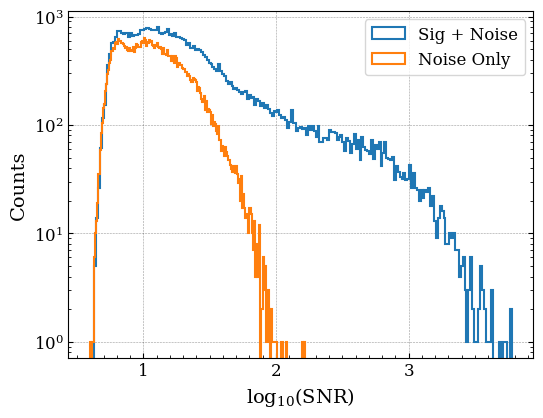

In [10]:
### Plotting the snr distributions

fig = plt.figure(figsize=(6,4.5))
ax = fig.add_subplot(111)

from matplotlib.ticker import MultipleLocator
ax.yaxis.set_minor_locator(MultipleLocator(50))
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(MultipleLocator(0.1))

ax.hist(np.log10(SNR_SigPlusNoise) ,bins=int(np.sqrt(len(SNR_SigPlusNoise))), histtype='step',linewidth=1.5, label="Sig + Noise")
ax.hist(np.log10(SNR_Background) ,bins=int(np.sqrt(len(SNR_Background))), histtype='step',linewidth=1.5, label="Noise Only")

# ax.set_title("Validation dataset", fontsize=9)
ax.grid(True, which="major", ls='--', lw=0.4, c='k', alpha=0.4)

ax.set_yscale("log")
# plt.text(.6,.75, 'IceCube Preliminary',color='r', ha='left', va='center', transform=ax.transAxes, fontsize=12)

ax.tick_params(axis='both', which='both', direction='in',labelsize=12)
ax.yaxis.set_ticks_position('both')
ax.yaxis.grid(linestyle="--", linewidth=0.4)
ax.xaxis.grid(linestyle="--", linewidth=0.4)

ax.set_xlabel(r"log$_{10}$(SNR)", fontsize=14)
ax.set_ylabel("Counts", fontsize=14)

plt.legend(loc='best', prop={'size': LegendFontSize})

# plt.savefig(PlotsDir+ f"/Validation_SNR_dist_{ant}.png", bbox_inches='tight', dpi=300);

# Applying Models:

In [11]:
## Normalizing
SigPlusNoise, SFactor_SigPlusNoise = Normalize(SigPlusNoise)
Background, SFactor_Background = Normalize(Background)

In [12]:
## Loading the classifier model
Classifier = load_model(model_Classifier, compile=False)

## Getting model predictions
sig_out = GetOutput(SigPlusNoise, Classifier)
noise_out = GetOutput(Background, Classifier)

2024-09-26 16:43:50.841181: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/icecube.opensciencegrid.org/py3-v4.2.1/Ubuntu_20.04_x86_64/lib:/cvmfs/icecube.opensciencegrid.org/py3-v4.2.1/Ubuntu_20.04_x86_64/lib64:/usr/local/cuda/lib64:/usr/local/cuda/lib64:/:/:/:/
2024-09-26 16:43:50.842370: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/icecube.opensciencegrid.org/py3-v4.2.1/Ubuntu_20.04_x86_64/lib:/cvmfs/icecube.opensciencegrid.org/py3-v4.2.1/Ubuntu_20.04_x86_64/lib64:/usr/local/cuda/lib64:/usr/local/cuda/lib64:/:/:/:/
2024-09-26 16:43:50.843414: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic libra

752/752 [==============================] - 6s 8ms/step


In [13]:
## Estimating the False positives
# THR = [0.4, 0.5, 0.6]
THR = [0.5]

FP_Percent = []
for thre in THR:
    fp_percent = ComputePercentPositives(noise_out, thre)
    FP_Percent.append(fp_percent)
    print(f"Thresold = {thre}, False Positive rate = {fp_percent}")

Thresold = 0.5, False Positive rate = 2.1926357395464944


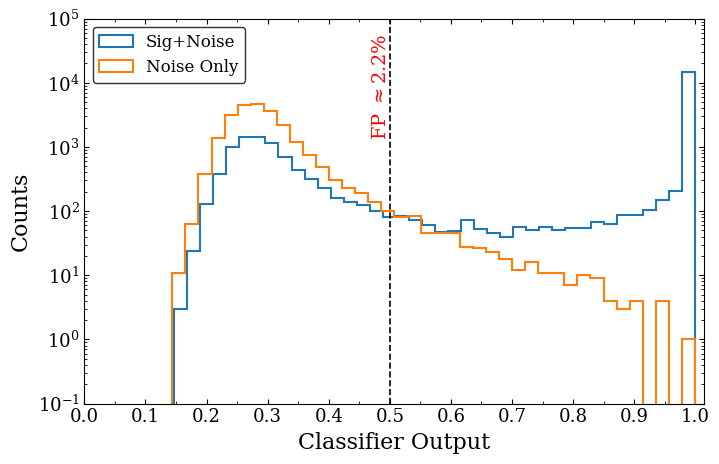

In [14]:
## Classifier output plot

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)

from matplotlib.ticker import MultipleLocator
ax.yaxis.set_minor_locator(MultipleLocator(1000))
ax.xaxis.set_minor_locator(MultipleLocator(0.05))
ax.xaxis.set_major_locator(MultipleLocator(0.1))
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')

ax.grid(True, which="major", ls='--', lw=0.4, c='k', alpha=0.4)

ax.hist(sig_out, bins=40, histtype='step',linewidth=1.5, alpha=1, label="Sig+Noise")
ax.hist(noise_out, bins=40, histtype='step',linewidth=1.5, alpha=1, label="Noise Only")

ax.set_yscale('log')

for thr, fpp, clr in zip(THR, FP_Percent, ['black', 'green', 'brown']):
    ax.axvline(x=thr,c= clr, ls='--', lw=1.2)
    ax.text(thr, 0.96, r'FP $\approx$'+f'{round(fpp,1)}%', color='red', ha='right', va='top', rotation=90,
                transform=ax.get_xaxis_transform(), fontsize=14)
    

# plt.text(.6,.94, 'IceCube Preliminary',color='r', ha='left', va='center', transform=ax.transAxes, fontsize=12)
ax.legend(loc=2, prop={'size': LegendFontSize}, edgecolor='black')

ax.set_xlabel("Classifier Output", fontsize=Axis_labelSize)
ax.set_ylabel("Counts", fontsize=Axis_labelSize)

ax.grid(False)

ax.set_xlim(0, 1.015)
ax.set_ylim(0.1, 1e5)

ax.tick_params(axis='both', which='both', direction='in',labelsize=13)
# plt.savefig(PlotsDir+ f"/Validation_ClassifierOutput_{ant}.png", bbox_inches='tight', dpi=300)

In [15]:
## We get only one output for both channels from the classifier: both channel receive the same score 
## Giving the scores to both channels, all ch0 1st
SigOut = np.concatenate((sig_out, sig_out))
NoiseOut = np.concatenate((noise_out, noise_out))

In [16]:
## Chossen threshold to compute TP and FP rates, with 99% rejection of background.
CL_threhold = 0.5

#####################################
# True Positives and False Positives
#####################################
## Bin the Sig + Noise data
centers = np.linspace( np.log10(min(SNR_SigPlusNoise)), np.log10(max(SNR_SigPlusNoise))-0.5, 15)

CLOut_Sig = [[] for i in range(len(centers))]  ## Binning the classifier output
SNR_Sig = [[] for i in range(len(centers))]
for i in range(len(SNR_SigPlusNoise)):
    icenter = np.argmin(np.abs(np.log10(SNR_SigPlusNoise[i])-centers))
    CLOut_Sig[icenter].append(SigOut[i])
    SNR_Sig[icenter].append(SNR_SigPlusNoise[i]) 

## For Background binning
centers = np.linspace( np.log10(min(SNR_Background))+0.1, np.log10(max(SNR_Background))-0.2, 8)

CLOut_Noise = [[] for i in range(len(centers))]  ## Classifier output binned
SNR_Noise = [[] for i in range(len(centers))]

for i in range(len(SNR_Background)):
    icenter = np.argmin(np.abs(np.log10(SNR_Background[i])-centers))
    CLOut_Noise[icenter].append(NoiseOut[i])
    SNR_Noise[icenter].append(SNR_Background[i])

## Get TP and FP
TruePositive = []
for Bin in CLOut_Sig:   ## For Sig Traces
    TruePositive.append(ComputePercentPositives(Bin, CL_threhold))
    
FalsePositive = []
for Bin in CLOut_Noise: ## For background
    FalsePositive.append(ComputePercentPositives(Bin, CL_threhold))

#### Bin Centers for x axis (SNR values)
Sig_BinCenters = [np.mean(elem) for elem in SNR_Sig]
Noise_BinCenters = [np.mean(elem) for elem in SNR_Noise]

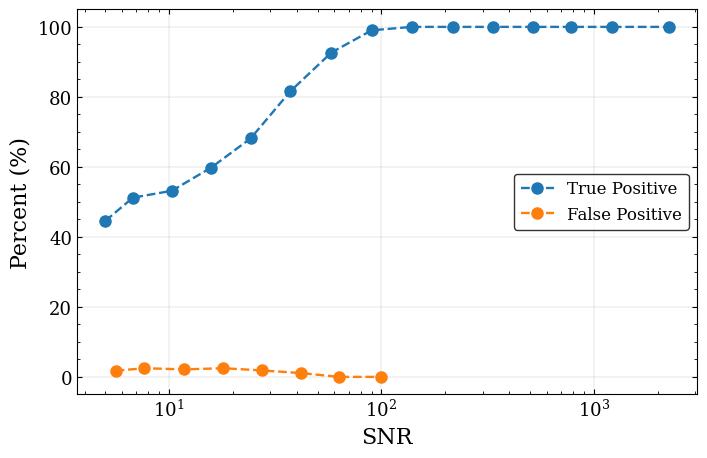

In [17]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)

from matplotlib.ticker import MultipleLocator
ax.yaxis.set_minor_locator(MultipleLocator(5))
ax.yaxis.set_major_locator(MultipleLocator(20))

ax.tick_params(axis='both', which='both', direction='in',labelsize=13);

ax.grid(True, which="major",ls='--', lw=0.1, c='k', alpha=1)
# ax.yaxis.grid(True, which='major',ls='--', lw=0.4, c='k', alpha=0.5)

ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')


ax.plot(Sig_BinCenters, TruePositive, 'o--', lw=1.7, ms=8, label= "True Positive")
ax.plot(Noise_BinCenters, FalsePositive, 'o--', lw =1.7, ms=8, label= "False Positive")
    
ax.set_xscale('log')

ax.set_xlabel("SNR", fontsize=Axis_labelSize)
ax.set_ylabel("Percent (%)", fontsize=Axis_labelSize)

ax.legend(loc=7, prop={'size': LegendFontSize}, edgecolor='black')

ymin, ymax = ax.get_ylim()
xmin, xmax = ax.get_xlim()
# plt.text(.08,.80, 'IceCube Preliminary',color='r', ha='left', va='center', transform=ax.transAxes, fontsize=12)

# ax.hlines(0, xmin, xmax, linestyles='dashed',linewidth=0.8, colors='k', alpha=0.5)  

ax.tick_params(axis='both', which='both', direction='in',labelsize=13)
# plt.savefig(PlotsDir+ f"/Validation_TPFP_{ant}.png", bbox_inches='tight', dpi=300);

# Denoiser Plots:

In [18]:
## First select only classified traces
## Indx of traces that passes the threshold
ClassifiedIndex = [i for i in range(len(sig_out)) if sig_out[i] > 0.5] 
print("Total no of traces = %d " % len(SigPlusNoise))        
print("No of Classified traces = %d " % len(ClassifiedIndex))

Total no of traces = 24035 
No of Classified traces = 16239 


In [19]:
#######################################
## Select only classifierd traces
SigPlusNoise = SigPlusNoise[ClassifiedIndex]
SFactor_SigPlusNoise = np.array(SFactor_SigPlusNoise)[ClassifiedIndex]
PureSignals = PureSignals[ClassifiedIndex]

In [20]:
## Split the traces agin to calculate the SNR for each channel trace
## Time consuming but good way to keep track of labels
SN_ch0, SN_ch1 = SigPlusNoise[:,:,0], SigPlusNoise[:,:,1]
## SNR Sig+Noise
snr_SN_ch0 = [GetSNR(i) for i in SN_ch0]
snr_SN_ch1 = [GetSNR(i) for i in SN_ch1]
SNR_Measured = np.concatenate((snr_SN_ch0, snr_SN_ch1))

In [21]:
### Loading the model and getting model predictions
Denoiser = load_model(model_Denoiser, compile=False)
## Predicting
DenoisedWaveforms = Denoiser.predict(SigPlusNoise)

508/508 [==============================] - 52s 103ms/step


In [22]:
## Rescaling the traces 
NoisyTraces = np.array([SigPlusNoise[i] * SFactor_SigPlusNoise[i] for i in range(len(SigPlusNoise))])
DenoisedTraces = np.array([DenoisedWaveforms[i] * SFactor_SigPlusNoise[i] for i in range(len(DenoisedWaveforms))])


### We want to upsample the traces and the esy way to do it is to create 1D arrays from 2D arrays
##
### Splitting the traces in to channel traces
SN_ch0, SN_ch1 = NoisyTraces[:,:, 0], NoisyTraces[:,:, 1]
deno_tr_ch0, deno_tr_ch1 = DenoisedTraces[:,:, 0], DenoisedTraces[:,:, 1]
Psig_tr_ch0, Psig_tr_ch1 = PureSignals[:,:, 0], PureSignals[:,:, 1]


### Combining the channel traces in a single array
noisy_traces = np.concatenate((SN_ch0, SN_ch1))
denoised_traces = np.concatenate((deno_tr_ch0, deno_tr_ch1))
pure_signals = np.concatenate((Psig_tr_ch0, Psig_tr_ch1))

In [23]:
######################################################################################
### Upsample the waveforms
### This take some memory and the kernel might die (if not enough memory is available on cluster)
### You can still reproduce the plots without running this cell however the time difference sub plot will be slightly different
###########################
from scipy import signal

##  Upsampling by a factor of 8
noisy_traces = [signal.resample(tr, 8000) for tr in noisy_traces ]
pure_signals = [signal.resample(tr, 8000) for tr in pure_signals ]
denoised_traces = [signal.resample(tr, 8000) for tr in denoised_traces ]

In [24]:
######################
### Finding Peak Times
######################
PeakTime_Noisy = [ np.argmax(np.abs(hilbert(trace))) for trace in noisy_traces ]
PeakTime_True = [ np.argmax(np.abs(hilbert(trace))) for trace in pure_signals ]
PeakTime_Denoised = [ np.argmax(np.abs(hilbert(trace))) for trace in denoised_traces ]

# ##### Peak Time Difference (Need to be careful if upsampling)
PTdiff_TrueMinusRaw = np.array(np.array(PeakTime_True) - np.array(PeakTime_Noisy) )*0.125
PTdiff_TrueMinusDeno = np.array(np.array(PeakTime_True) - np.array(PeakTime_Denoised))*0.125

# ##### Peak Time Difference
# PTdiff_TrueMinusRaw = np.array(np.array(PeakTime_True) - np.array(PeakTime_Noisy) )
# PTdiff_TrueMinusDeno = np.array(np.array(PeakTime_True) - np.array(PeakTime_Denoised))

In [25]:
########################
### Finding Power Ratios
########################
PowerRatio_Trad = [GetPowerRatio(pure_signals[i], noisy_traces[i]) for i in range(len(pure_signals))]##(Noisy/True) 
PowerRatio_NN = [GetPowerRatio(pure_signals[i], denoised_traces[i]) for i in range(len(pure_signals))]##(Deno/True)

In [26]:
## Binning the data (with respect to SNR)
# centers = np.linspace( np.log10(min(SNR_Measured))+0.1, np.log10(max(SNR_Measured))-1.0, 10)

Leftcent = np.linspace( np.log10(min(SNR_Measured))+0.1, np.log10(100), 8)
Rightcent = np.linspace( np.log10(100)+0.2, np.log10(max(SNR_Measured))-0.2, 4)

centers = list(Leftcent) + list(Rightcent)

PtDiff_Trad = [[] for i in range(len(centers))] ## Peak Time Difference
PtDiff_NN = [[] for i in range(len(centers))]

PWRRatio_Trad = [[] for i in range(len(centers))] ## Power Ratio
PWRRatio_NN = [[] for i in range(len(centers))]

SNRBinned = [[] for i in range(len(centers))]

for i in range(len(SNR_Measured)):
    icenter = np.argmin(np.abs(np.log10(SNR_Measured[i])-centers))
    
    PtDiff_Trad[icenter].append(PTdiff_TrueMinusRaw[i])
    PtDiff_NN[icenter].append(PTdiff_TrueMinusDeno[i])
    
    PWRRatio_Trad[icenter].append(PowerRatio_Trad[i])
    PWRRatio_NN[icenter].append(PowerRatio_NN[i])
    
    SNRBinned[icenter].append(SNR_Measured[i])

In [27]:
def GetStatsNumpy(array):
    ## Calculate the median and 68%
    array_sorted = np.sort(array)
    median = np.median(array_sorted) ### Mean (Median)
    percentile_16 = np.percentile(array_sorted, 16)
    percentile_84 = np.percentile(array_sorted, 84)
    
    OneSigma = percentile_84 - percentile_16  ### 68% containment
    YerrHigh = percentile_84 - median ## difference from the medain
    YerrLow = median - percentile_16 ## difference from the medain
    
    return median, OneSigma, YerrHigh, YerrLow

In [28]:
## Computing the stats
SNRBinCenters = [np.median(elem) for elem in SNRBinned]
####################### Arrival Time Diff ######################################
### Traditional
TdiffMean_Trad, TdiffStd_Trad = [], []
YerrLow, YerrHigh = [], []
for entry in PtDiff_Trad:
    median, sigma, yer_High, yer_Low = GetStatsNumpy(entry)
    entry.sort() ## Sorting
    TdiffMean_Trad.append( median ) ### Mean (Median)
    TdiffStd_Trad.append( sigma ) ### 68% containment
    YerrHigh.append( yer_High ) ## difference from the medain
    YerrLow.append( yer_Low ) ## difference from the medain

### NN Method
TdiffMean_NN, TdiffStd_NN = [], []
YerrLow_NN, YerrHigh_NN = [], []
for entry in PtDiff_NN:
    median, sigma, yer_High, yer_Low = GetStatsNumpy(entry)
    TdiffMean_NN.append( median ) ### Mean (Median)
    TdiffStd_NN.append( sigma ) ### 68% containment
    YerrHigh_NN.append( yer_High ) ## difference from the medain
    YerrLow_NN.append( yer_Low )## difference from the medain

####################   Power Ratio ############################################
### Traditional
PowerRatioMean_Trad, PowerRatioStd_Trad = [], []
elow, ehigh =[], []
for entry in PWRRatio_Trad:
    median, sigma, yer_High, yer_Low = GetStatsNumpy(entry)
    PowerRatioMean_Trad.append( median )
    PowerRatioStd_Trad.append( sigma )
    ehigh.append( yer_High )
    elow.append( yer_Low )
    
### NN Method
PowerRatioMean_NN, PowerRatioStd_NN = [], []
elowNN, ehighNN =[], []
for entry in PWRRatio_NN:   ### NN method
    median, sigma, yer_High, yer_Low = GetStatsNumpy(entry)
    PowerRatioMean_NN.append( median )
    PowerRatioStd_NN.append( sigma )
    ehighNN.append( yer_High )
    elowNN.append( yer_Low )
################################################################

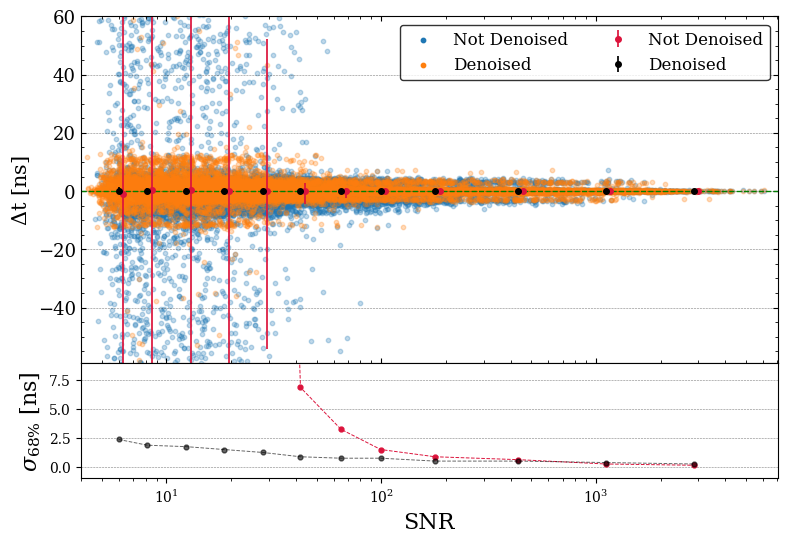

In [29]:
from matplotlib.ticker import MultipleLocator


gs = gridspec.GridSpec(2, 1, wspace=0.025, hspace=0, width_ratios=[1], height_ratios=[0.75, 0.25])
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(gs[0])
ax.yaxis.set_minor_locator(MultipleLocator(5))
ax.tick_params(axis='both', which='both', direction='in',labelsize=13)

Circlesize=10
ErrorCircle=8.0
Elinewidth=1.25

ax.scatter(SNR_Measured, PTdiff_TrueMinusRaw,c="#1f77b4",  s=Circlesize, alpha=0.28)
ax.scatter(SNR_Measured, PTdiff_TrueMinusDeno, c="#ff7f0e", s=Circlesize, alpha=0.28)
ax.scatter([], [], c='#1f77b4', s=Circlesize, label='Not Denoised') ## For showing the labels, remove the earlier label
ax.scatter([], [], c='#ff7f0e', s=Circlesize, label='Denoised') ## For showing the labels, remove the earlier label

ax.errorbar(np.array(SNRBinCenters)*1.05, TdiffMean_Trad, yerr=[YerrLow, YerrHigh], c='crimson',  fmt='.',ms = ErrorCircle, elinewidth=Elinewidth,\
            label='Not Denoised')
ax.errorbar(SNRBinCenters, TdiffMean_NN, yerr=[YerrLow_NN, YerrHigh_NN], c='k',  fmt='.',ms=ErrorCircle, elinewidth=Elinewidth, label='Denoised')

ax.yaxis.set_ticks_position('both') ## Positions of ticks
ax.xaxis.set_ticks_position('both')


ax.set_xscale('log')
ax.set_ylim(-59,60)

ax.set_ylabel(r"$\Delta$t [ns]", fontsize=15)

# ax.grid(True, which="both", axis='both', ls='--', lw=0.3, c='k', alpha=0.5)
ax.legend(loc='best', prop={'size': LegendFontSize}, ncol=2,  edgecolor='black')

ax.set_xticklabels([])


ax.yaxis.grid(True, which='major',ls='--', lw=0.4, c='k', alpha=0.5)
ax.axhline(0, ls='dashed', lw=1, color='g')

Xlim = (10**0.6, max(SNR_Measured)+1000)
ax.set_xlim(Xlim)

ax = fig.add_subplot(gs[1])
ax.set_xscale('log')

ax.yaxis.grid(True, which='major',ls='--', lw=0.4, c='k', alpha=0.5)

## For setting minor ticks
import matplotlib

ax.plot(SNRBinCenters, TdiffStd_Trad, 'o--', lw=0.7, c='crimson', markersize=3.5, alpha=1)
ax.plot(SNRBinCenters, TdiffStd_NN, 'o--', lw=0.7, c='k', markersize=3.5, alpha=0.6)

# ax.set_yscale("log")
ax.set_xlim(Xlim)

# ax.set_ylim(bottom=0.01)
ax.set_ylim(-1,9)


ax.set_xlabel("SNR", fontsize=Axis_labelSize)
ax.set_ylabel(r"$\sigma_{\rm 68\%}$ [ns]", fontsize=Axis_labelSize);

# plt.savefig(PlotsDir + f"/Validation_TimeDiff_{ant}.png", bbox_inches='tight', dpi=300);

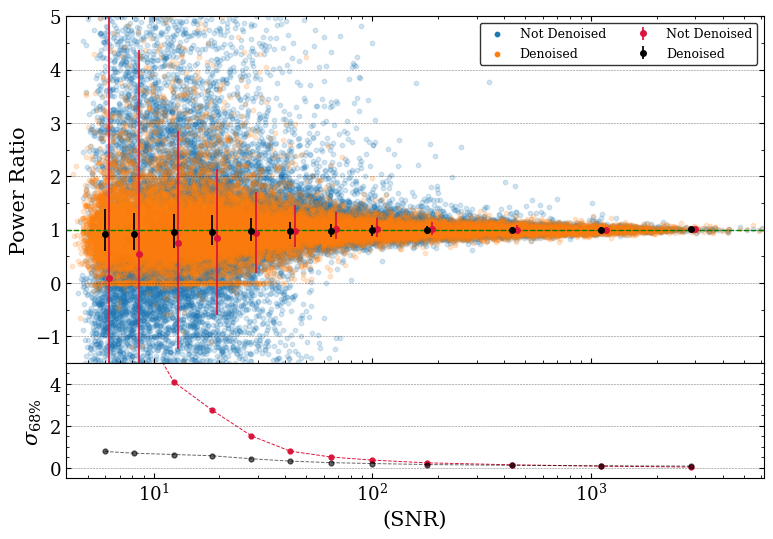

In [30]:
from matplotlib.ticker import MultipleLocator

gs = gridspec.GridSpec(2, 1, wspace=0.025, hspace=0, width_ratios=[1], height_ratios=[0.75, 0.25])
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(gs[0])
ax.tick_params(axis='both', which='both', direction='in',labelsize=13)
ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(MultipleLocator(0.5))

ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')

ax.scatter(SNR_Measured, PowerRatio_Trad,c="#1f77b4",s=10, alpha=0.18)
ax.scatter(SNR_Measured, PowerRatio_NN, c="#ff7f0e",s=10, alpha=0.18)
ax.scatter([], [],c="#1f77b4", s=10, label='Not Denoised') ## For showing the labels, remove the earlier label
ax.scatter([], [], c="#ff7f0e", s=10, label='Denoised') ## For showing the labels, remove the earlier label

ax.errorbar(np.array(SNRBinCenters)*1.05, PowerRatioMean_Trad, yerr=[elow, ehigh], c='crimson', elinewidth=Elinewidth,  fmt='.',ms = ErrorCircle,label='Not Denoised')
ax.errorbar(SNRBinCenters, PowerRatioMean_NN, yerr=[elowNN, ehighNN], c='k', elinewidth=Elinewidth,  fmt='.',ms = ErrorCircle, label='Denoised')

ax.axhline(1.0, ls='dashed', lw=1, color='g')


ax.set_xscale('log')
ax.set_ylim(-1.5,5)
ax.set_xlim(10**0.6, max(SNR_Measured)+100)
ax.set_ylabel("Power Ratio", fontsize=15)
ax.legend(loc='best', prop={'size': 9}, ncol=2,  edgecolor='black')

ax.tick_params(axis='both', which='both', direction='in',labelsize=13);

# ax.grid(True, which="both", axis='both', ls='--', lw=0.3, c='k', alpha=0.5)
ax.yaxis.grid(True, which='major',ls='--', lw=0.4, c='k', alpha=0.5)


ax.set_xticklabels([])


ax = fig.add_subplot(gs[1])
ax.xaxis.set_minor_locator(MultipleLocator(10))

ax.yaxis.set_minor_locator(MultipleLocator(0.5))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_ticks_position('both')

ax.tick_params(axis='both', which='both', direction='in',labelsize=13);

ax.plot(SNRBinCenters, PowerRatioStd_Trad, 'o--', lw=0.7,c='crimson', markersize=3.5,alpha=1)
ax.plot(SNRBinCenters, PowerRatioStd_NN, 'o--', lw=0.7,c='k', markersize=3.5,alpha=0.6)
ax.set_yticks([0,2,4])
# ax.grid(True, which="both", axis='both', ls='--', lw=0.3, c='k', alpha=0.5)
ax.yaxis.grid(True, which='major',ls='--', lw=0.4, c='k', alpha=0.5)

# ax.axhline(0.0, ls='dashed', lw=1, color='g')

ax.set_xscale('log')
ax.set_ylim(-0.5,5.0)
ax.set_xlim(10**0.6, max(SNR_Measured)+100)
ax.set_xlabel("(SNR)", fontsize=15)
ax.set_ylabel(r"$\sigma_{\rm 68\%}$ ", fontsize=15);
# plt.savefig(PlotsDir + f"/Validation_PowerRatio_{ant}.png", bbox_inches='tight', dpi=300);

# Denoising Example Waveforms:

In [31]:
def GetSpectra(trace):
    fft_result = np.fft.fft(trace)
    n = len(trace)
    Spec = np.abs(fft_result[:n//2])

    return np.array(Spec)

In [32]:
# def GetSpectra(trace):
#     fft_result = np.fft.fft(trace)
#     n = len(trace)
#     Spec = np.abs(fft_result[:n//2])

#     return np.array(Spec)

def MakePlot(Noisy, Denoised, Pure, index=2, ylim=0.3, y_text=0.115):
    
    ## Ch 0
    noisy = Noisy[index][:, 0]/1e-12
    denoised = Denoised[index][:, 0]/1e-12
    pure = Pure[index][:, 0]/1e-12
    
    
    lfs = 11 # labels font size
    
    fig = plt.figure(figsize=(13,4.5))
    plt.subplots_adjust(wspace=0.17) 
    plt.subplots_adjust(hspace=0.06)
    
    ax = fig.add_subplot(221)
    
    ax.plot(noisy, c='skyblue',  lw=0.8,  alpha=1.0, label=f"SNR={round(GetSNR(noisy),1)}")
    ax.plot(denoised,c='red',    lw=1.2,  alpha=0.7, label=f"SNR={round(GetSNR(denoised),1)}")
    ax.plot(pure,"--",c='black', lw=0.8,  alpha=0.7)

    ax.legend(loc="best", ncol = 3, columnspacing=0.3, fontsize=9)
    
    
    plt.ylabel("Amp [mV]", fontsize=lfs)
#     plt.xlabel("Times [ns]", fontsize=lfs)
    ax.set_xlim( 0, 1000 )
    ax.set_ylim( -ylim, ylim )
    
    ax.tick_params(axis='both', which='both', direction='in',labelsize=11);
    
    frame1 = plt.gca()
    frame1.axes.xaxis.set_ticklabels([])
    
    
    ax = fig.add_subplot(222)
    frame1 = plt.gca()
    frame1.axes.xaxis.set_ticklabels([])
    
    ax.plot( GetSpectra(noisy), c='skyblue',  lw=1.2,  alpha=1,   label="Noisy")
    ax.plot( GetSpectra(denoised), c='red',   lw=1.2,  alpha=0.7, label="Denoised")
    ax.plot( GetSpectra(pure),"--", c='black', lw=1.2, alpha=0.7, label="True")
    ax.legend(loc="best", ncol = 3, columnspacing=0.3, fontsize=9)

#     plt.text(40,y_text , "Ant1_Ch0", fontsize=10, bbox=dict(facecolor='none', edgecolor='grey', boxstyle='round,pad=0.5'))
    
    ax.tick_params(axis='both', which='both', direction='in',labelsize=11);
    
    plt.yscale('log')
    plt.ylabel("Amp [mV/MHz]", fontsize=lfs)
#     plt.xlabel("Freqs [MHz]", fontsize=lfs)
    
    ax.set_xlim( 40, 370 )
    ax.set_ylim( 1e-3, 1e2 )
    
    
    ##### For Channel 1
    noisy = Noisy[index][:, 1]/1e-12
    denoised = Denoised[index][:, 1]/1e-12
    pure = Pure[index][:, 1]/1e-12
        
    ax = fig.add_subplot(223)
    ax.plot(noisy, c='skyblue',  lw=0.8,  alpha=1.0, label=f"SNR={round(GetSNR(noisy),1)}")
    ax.plot(denoised,c='red',    lw=1.2,  alpha=0.7, label=f"SNR={round(GetSNR(denoised),1)}")
    ax.plot(pure,"--",c='black', lw=0.8,  alpha=0.7)

    ax.legend(loc="best", ncol = 3, columnspacing=0.3, fontsize=9)
    
    plt.ylabel("Amp [mV]", fontsize=lfs)
    plt.xlabel("Times [ns]", fontsize=lfs)
    ax.set_xlim( 0, 1000 )
    ax.set_ylim( -ylim, ylim )
    
    ax.tick_params(axis='both', which='both', direction='in',labelsize=11);
    
    
    ax = fig.add_subplot(224)
    ax.plot( GetSpectra(noisy), c='skyblue',  lw=1.2,  alpha=1,   label="Noisy")
    ax.plot( GetSpectra(denoised), c='red',   lw=1.2,  alpha=0.7, label="Denoised")
    ax.plot( GetSpectra(pure),"--", c='black', lw=1.2, alpha=0.7, label="True")
    
#     ax.legend(loc="best", ncol = 3, columnspacing=0.3, fontsize=11)
    plt.yscale('log')
    plt.ylabel("Amp [mV/MHz]", fontsize=lfs)
    plt.xlabel("Freqs [MHz]", fontsize=lfs)
    ax.tick_params(axis='both', which='both', direction='in',labelsize=11);
#     plt.text(90,y_text , "Ant1_Ch1", fontsize=10, bbox=dict(facecolor='none', edgecolor='grey', boxstyle='round,pad=0.5'))
    
    ax.set_xlim( 40, 370 )
    ax.set_ylim( 1e-3, 1e2 )

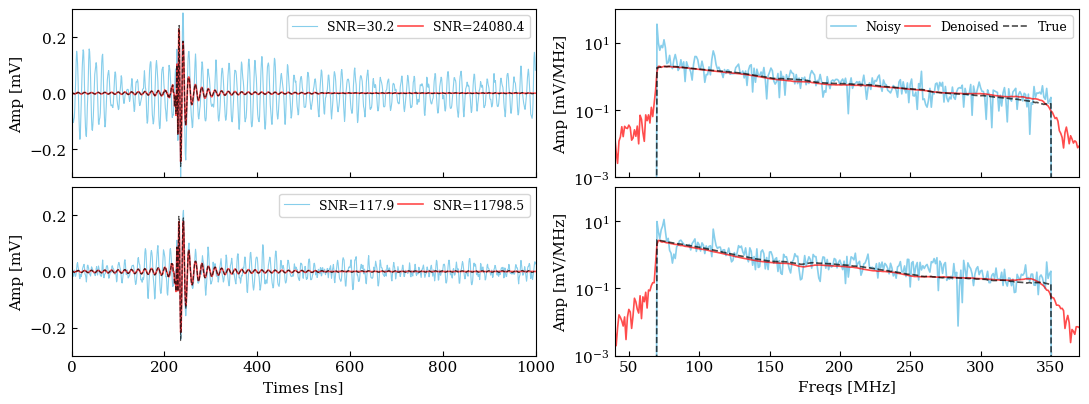

In [33]:
# [2, 77, 167, 231, 243]
ii = 2

MakePlot(NoisyTraces, DenoisedTraces, PureSignals, 2)
# plt.savefig('./Denoising_example.pdf' , bbox_inches='tight');
# plt.savefig('./Denoising_example.png' , bbox_inches='tight',  dpi=300);

In [ ]:
Ind = []
for i in range(len(SNR_Measured)):
#     if SNR_Measured[i] < 1*10**2:
    if SNR_Measured[i] > 1*10**2:
        if PowerRatio_NN[i] > 0.9 and PowerRatio_NN[i] < 1.1:
            if PTdiff_TrueMinusDeno[i] > 3:
#             if PTdiff_TrueMinusDeno[i] > 10:
                
                Ind.append(i)